In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
import seaborn as sns
import itertools
from matplotlib.lines import Line2D
import matplotlib.pylab as plb
from sklearn.linear_model import LinearRegression
import matplotlib.style as style
from matplotlib.patches import Patch
#import pyam

# data_path = "/Users/Broccolee/Google Drive/Grad School/TU BERLIN/Negative Emissions & Carbon Markets/Data/"
# plot_path = "/Users/Broccolee/Google Drive/Grad School/TU BERLIN/Negative Emissions & Carbon Markets/Plots/"

data_path = "/Users/kaylinlee/Desktop/KL_ISIpedia/Thesis/Code/Data/"
plot_path = "/Users/kaylinlee/Desktop/KL_ISIpedia/Thesis/Code/Plots/"

pd.set_option('display.max_columns', 500)

In [2]:
main_remind=pd.read_excel(data_path+'REMIND_processed_output_FAO.xls')
main_image=pd.read_excel(data_path+'IMAGE_processed_output_FAO.xls')
#main_strefler=pd.read_excel(data_path+'STREFLER_processed_output_inkl2015.xls')
#main_message=pd.read_excel(data_path+'MESSAGE_processed_output_FAO.xls')

In [3]:
regions_rem = ['AFR', 'CHN', 'EUR', 'IND', 'JPN', 'LAM', 'MEA', 'OAS', 'ROW', 'RUS', 'USA', 'World']
regions_ima = ['BRA', 'CAN', 'CEU', 'CHN', 'EAF', 'INDIA', 'INDO', 'JAP', 'KOR', 'ME', 'MEX', 'NAF',
 'OCE', 'RCAM', 'RSAF', 'RSAM', 'RSAS', 'RUS', 'SAF', 'SEAS', 'STAN', 'TUR', 'UKR',
 'USA', 'WAF', 'WEU', 'World']
regions_mes = ['CHN', 'EU', 'IND', 'R11_AFR', 'R11_FSU', 'R11_LAM','R11_MEA', 'R11_PAO', 'R11_PAS', 'USA', 'World']

regions_rem_noworld = ['AFR', 'CHN', 'EUR', 'IND', 'JPN', 'LAM', 'MEA', 'OAS', 'ROW', 'RUS', 'USA']
regions_ima_noworld = ['BRA', 'CAN', 'CEU', 'CHN', 'EAF', 'INDIA', 'INDO', 'JAP', 'KOR', 'ME', 'MEX', 'NAF',
 'OCE', 'RCAM', 'RSAF', 'RSAM', 'RSAS', 'RUS', 'SAF', 'SEAS', 'STAN', 'TUR', 'UKR',
 'USA', 'WAF', 'WEU']
regions_mes_noworld = ['CHN', 'EU', 'IND', 'R11_AFR', 'R11_FSU', 'R11_LAM','R11_MEA', 'R11_PAO', 'R11_PAS',  'USA']


def GDP_cap_calc(main_df, regions_names):
    main_df['GDP'] = main_df['GDP']*1000
    main_df['Unit_GDP'] = 'USD Million'
    main_df['GDP_cap'] = 0
    main_df['GDP_cap_avg'] = 0
    wfilt = (main_df.Region == 'World')

    for scen in main_df.Scenario.unique():
            rfilt=(main_df.Region.isin(regions_names))
            sfilt=(main_df.Scenario==scen)

            for yr in main_df.Year.unique(): 
                yrfilt=(main_df.Year==yr)
                main_df.loc[sfilt&yrfilt&rfilt,
                            'GDP_cap'] = main_df.loc[
                    rfilt&yrfilt&sfilt,'GDP'].values/main_df.loc[rfilt&yrfilt&sfilt,'Population'].values  
                main_df.loc[sfilt&yrfilt&rfilt,
                            'GDP_cap_avg'] = sum(main_df.loc[wfilt&sfilt&yrfilt, 'GDP_cap'])
    return main_df

main_image = GDP_cap_calc(main_image, regions_ima)
main_remind = GDP_cap_calc(main_remind, regions_rem)
#main_message = GDP_cap_calc(main_message, regions_mes)
#main_strefler = GDP_cap_calc(main_strefler, regions_rem)


In [5]:
#turn below average GDP values to Nan -> exclued countries whose GDP per cap is below avg 
#to calculate which countries will receive how much finance, skip this part - NOT 
def CoI_calc(main_df):

    mask = (main_df['GDP_cap'].values > main_df['GDP_cap_avg'].values)

    main_df['GDP_cap_CoI_nan'] = np.where(mask, main_df['GDP_cap'], np.nan)
    main_df['GDP_cap_CoI'] = np.where(mask, main_df['GDP_cap'], 0)
    main_df['GDP_CoI_nan'] = np.where(mask, main_df['GDP'], np.nan)
    main_df['GDP_CoI'] = np.where(mask, main_df['GDP'], 0)

    return main_df

main_image = CoI_calc(main_image)
main_remind = CoI_calc(main_remind)
#main_message = CoI_calc(main_message)
#main_strefler = CoI_calc(main_strefler)
    
#print(main_remind.loc[(main_remind.Region == 'AFR')&(main_remind.Scenario == 'SSP1-19-SPA1-V17')])
#print(main_remind.loc[(main_remind.Region == 'JPN')&(main_remind.Scenario == 'SSP2-19-SPA2-V17')])
#print(main_image.loc[(main_image.Region == 'JAP')&(main_image.Scenario == 'SSP1-19-SPA0-V17')])
#print(main_image.loc[(main_image.Region == 'INDIA')&(main_image.Scenario == 'SSP2-LF-SPA2-V17')])
#print(main_message.loc[(main_message.Region == 'IND')&(main_message.Scenario == 'SSP1-19')])

# Fair share by GDP

In [6]:
def GDP_CoI_frac_calc(main_df, regions_names_noworld):    
    main_df['GDP_CoI_frac'] = 0

    for scen in main_df.Scenario.unique():
            rfilt=(main_df.Region.isin(regions_names_noworld))
            sfilt=(main_df.Scenario==scen)

            for yr in main_df.Year.unique(): 
                yrfilt=(main_df.Year==yr)
                tot_GDP_yr = main_df.loc[sfilt&yrfilt&rfilt,'GDP_CoI'].sum()
                main_df.loc[sfilt&yrfilt&rfilt,
                            'GDP_CoI_frac'] = (main_df.loc[rfilt&sfilt&yrfilt,'GDP_CoI'])/tot_GDP_yr
                main_df.loc[sfilt&yrfilt&rfilt,
                            'CDR_fair_share_by_GDP'] = (main_df.loc[rfilt&sfilt&yrfilt,'GDP_CoI_frac']
                                                       )*(main_df.loc[sfilt&yrfilt&(main_df.Region=='World'),'TOTAL_CDR'].values)
                main_df.loc[sfilt&yrfilt&rfilt,
                            'BECCS_fair_share_by_GDP'] = (main_df.loc[rfilt&sfilt&yrfilt,'GDP_CoI_frac']
                                                       )*(main_df.loc[sfilt&yrfilt&(main_df.Region=='World'),'BECCS'].values)

#                 main_df.loc[sfilt&yrfilt&rfilt,
#                             'CDR_fair_share_by_GDPXCarbonPrice'] = (main_df.loc[rfilt&sfilt&yrfilt,'CDR_fair_share_by_GDP'].values
#                                                                    )*(main_df.loc[sfilt&yrfilt&rfilt,'Carbon_Price'].values)*1000000
                main_df.loc[sfilt&yrfilt&rfilt,
                            'BECCS_investments_by_GDP'] = (main_df.loc[rfilt&sfilt&yrfilt,'GDP_CoI_frac']
                                                          )*(main_df.loc[sfilt&yrfilt&(main_df.Region=='World'),'BECCS_Investments'].values)
                              
    main_df['CUM_CDR_fair_share_by_GDP'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_CDR_fair_share_by_GDP'] = main_df.loc[(main_df.Year == 2020), 'CDR_fair_share_by_GDP'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld:
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.CDR_fair_share_by_GDP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_CDR_fair_share_by_GDP'] += integral
            main_df.loc[mask,'CUM_CDR_fair_share_by_GDP'] = full_reg.loc[:,'CUM_CDR_fair_share_by_GDP']
    #adding only BECCS values
    main_df['CUM_BECCS_fair_share_by_GDP'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_fair_share_by_GDP'] = main_df.loc[(main_df.Year == 2020), 'BECCS_fair_share_by_GDP'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld:
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.BECCS_fair_share_by_GDP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_BECCS_fair_share_by_GDP'] += integral
            main_df.loc[mask,'CUM_BECCS_fair_share_by_GDP'] = full_reg.loc[:,'CUM_BECCS_fair_share_by_GDP']

    main_df['CUM_BECCS_investments_by_GDP'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_investments_by_GDP'] = main_df.loc[(main_df.Year == 2020), 'BECCS_investments_by_GDP'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld:
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.BECCS_investments_by_GDP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_BECCS_investments_by_GDP'] += integral
            main_df.loc[mask,'CUM_BECCS_investments_by_GDP'] = full_reg.loc[:,'CUM_BECCS_investments_by_GDP']
                

#     main_df['CUM_PriceXTotalCDR'] = 0
#     for scen in main_df.Scenario.unique():
#         for reg in main_df.Region.unique():
#             main_df.loc[(main_df.Year == 2020), 'CUM_PriceXTotalCDR'] = main_df.loc[(main_df.Year == 2020), 'PriceXTotalCDR'] 

#     for reg in main_df.Region.unique():
#         if reg in regions_names_noworld:
#             mask = main_df.Region == reg
#             full_reg = main_df.loc[mask,:]

#             for scen in full_reg.Scenario.unique():
#                 mask_scen = full_reg.Scenario == scen
#                 full_scen = full_reg.loc[mask_scen,:]
#                 integral = integrate.cumtrapz(y = full_scen.PriceXTotalCDR, x = full_scen.Year, initial = 0)
#                 full_reg.loc[mask_scen,'CUM_PriceXTotalCDR'] += integral
#             main_df.loc[mask,'CUM_PriceXTotalCDR'] = full_reg.loc[:,'CUM_PriceXTotalCDR']

#     main_df['CUM_CDR_fair_share_by_GDPXCarbonPrice'] = 0
#     for scen in main_df.Scenario.unique():
#         for reg in main_df.Region.unique():
#             main_df.loc[(main_df.Year == 2020), 'CUM_CDR_fair_share_by_GDPXCarbonPrice'] = main_df.loc[(main_df.Year == 2020), 'CDR_fair_share_by_GDPXCarbonPrice'] 

#     for reg in main_df.Region.unique():
#         if reg in regions_names_noworld:
#             mask = main_df.Region == reg
#             full_reg = main_df.loc[mask,:]

#             for scen in full_reg.Scenario.unique():
#                 mask_scen = full_reg.Scenario == scen
#                 full_scen = full_reg.loc[mask_scen,:]
#                 integral = integrate.cumtrapz(y = full_scen.CDR_fair_share_by_GDPXCarbonPrice, x = full_scen.Year, initial = 0)
#                 full_reg.loc[mask_scen,'CUM_CDR_fair_share_by_GDPXCarbonPrice'] += integral
#             main_df.loc[mask,'CUM_CDR_fair_share_by_GDPXCarbonPrice'] = full_reg.loc[:,'CUM_CDR_fair_share_by_GDPXCarbonPrice']
    
    return main_df

main_remind = GDP_CoI_frac_calc(main_remind, regions_rem_noworld)
main_image = GDP_CoI_frac_calc(main_image, regions_ima_noworld)
#main_message = GDP_CoI_frac_calc(main_message, regions_mes_noworld)
#main_strefler = GDP_CoI_frac_calc(main_strefler, regions_rem_noworld)
            
#print(main_remind.loc[(main_remind.Region == 'USA')&(main_remind.Scenario == 'SSP1-19-SPA1-V17')])
#print(main_remind.loc[(main_remind.Region == 'World')&(main_remind.Scenario == 'SSP1-19-SPA1-V17')])
#print(main_strefler.loc[(main_strefler.Region == 'USA')&(main_strefler.Scenario == '20-SSP1-optimal-ccs20')])
#print(main_strefler.loc[(main_strefler.Region == 'World')&(main_strefler.Scenario == '20-SSP1-optimal-ccs20')])
#print(main_remind.loc[(main_remind.Region == 'CHN')&(main_remind.Scenario == 'SSP1-19-SPA1-V17')])
#print(main_image.loc[(main_image.Region == 'USA')&(main_image.Scenario == 'SSP1-19-SPA0-V17')])
#print(main_image.loc[(main_image.Region == 'CHN')&(main_image.Scenario == 'SSP1-19-SPA0-V17')])

/Users/kaylinlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [8]:
main_remind[['BECCS','BECCS_fair_share_by_GDP','CUM_BECCS_fair_share_by_GDP']]

,BECCS,BECCS_fair_share_by_GDP,CUM_BECCS_fair_share_by_GDP
0,0.006,0.0,0.0
1,30.860,0.0,0.0
2,352.200,0.0,0.0
3,949.000,0.0,0.0
4,1144.000,0.0,0.0
...,...,...,...
643,14030.000,NaN,0.0
644,17190.000,NaN,0.0
645,19390.000,NaN,0.0
646,20980.000,NaN,0.0


Nan for all "world" values

# Fair share by emissions per capita

In [7]:
"""%% EQUITY CALCULATION - CUMULATIVE EMISSIONS PER CUMULATIVE CAPITA
At each point in time calculate the cumulative emissions divided by the cumulative population for the world,
...then multiply this value by the population of each country to find the fair share of emissions
...then find the difference between fair share emissions and actual emissions - this is the required negative emissions
"""

def equity_calc(main_df):

    # DERIVE WORLD FAIR SHARE BOTH GDP AND POPULATION

    main_df['Global_CUM_CO2_by_CUM_POP']=np.nan
    #main_df['Global_CUM_CO2_by_GDP']=np.nan
    #main_df['Fair_share_by_GDP']=np.nan
    main_df['Fair_share_by_CUM_POP']=np.nan
    #main_df['Excess_emissions_by_GDP']=np.nan
    main_df['Excess_emissions_by_CUM_POP']=np.nan
    main_df['Exc_em_fac_by_CUM_POP']=np.nan
    #main_df['Exc_em_fac_by_GDP']=np.nan

    # Set to zero instead of NAN, for regions who have 'negative' CDR reliabilities
    main_df['CDR_fair_share_by_CUM_POP']=0
    main_df['BECCS_fair_share_by_CUM_POP']=0
    #main_df['CDR_fair_share_by_GDP']=0
    main_df['CUM_CDR_fair_share_by_CUM_POP']=0
    main_df['CUM_BECCS_fair_share_by_CUM_POP']=0
    #main_df['CUM_CDR_fair_share_by_GDP']=0
    main_df['CDR_model_vs_fair_share_by_CUM_POP']=0
    main_df['CDR_model_vs_fair_share_by_GDP']=0
    main_df['CUM_CDR_model_vs_fair_share_by_CUM_POP']=0
    main_df['CUM_CDR_model_vs_fair_share_by_GDP']=0
    
    # add BECCS investment fair share
    main_df['BECCS_Investments_by_POP']=0
    main_df['CUM_BECCS_Investments_by_POP']=0
    
    #add (carbon price X CDR (model & fair share)) both by GDP and cum pop
#     main_df['CDR_fair_share_by_CUM_POPXCarbonPrice']=0
#     main_df['CDR_model_vs_FairShareXCarbonPrice_by_GDP']=0
#     main_df['CDR_model_vs_FairShareXCarbonPrice_by_POP']=0
    
    # Derive World Average 
    reg='World'
    for scen in main_df.Scenario.unique():
        rfilt=(main_df.Region==reg)
        sfilt=(main_df.Scenario==scen)

        for yr in main_df.Year.unique():    
            yrfilt=(main_df.Year==yr)
            main_df.loc[sfilt&yrfilt,
                        'Global_CUM_CO2_by_CUM_POP']=main_df.loc[
                rfilt&yrfilt&sfilt,'CUM_CO2'].values/main_df.loc[rfilt&yrfilt&sfilt,'cumPopulation'].values  #cumPop & CUM_CO2of world


          #  main_df.loc[sfilt&yrfilt,
          #          'Global_CUM_CO2_by_GDP']=main_df.loc[
          #      rfilt&yrfilt&sfilt,'CUM_CO2'].values/main_df.loc[rfilt&yrfilt&sfilt,'GDP'].values


    # Derive country fair share population based    
    main_df['Fair_share_by_CUM_POP']=main_df['Global_CUM_CO2_by_CUM_POP']*main_df['cumPopulation']      #cumPop of single Region?
  #  main_df['Fair_share_by_GDP']=main_df['Global_CUM_CO2_by_GDP']*main_df['GDP']
    
    # Derive difference between fair share and actual emissions
    main_df['Excess_emissions_by_CUM_POP']=main_df['CUM_CO2']-main_df['Fair_share_by_CUM_POP']
  #  main_df['Excess_emissions_by_GDP']=main_df['CUM_CO2']-main_df['Fair_share_by_GDP']

    rfilt_wo_world=(main_df.Region!='World')
    # Derive total burden for countries
    for yr in main_df.Year.unique():
        yrfilt=(main_df.Year==yr)
        for scen in main_df.Scenario.unique():
            scen_filt=(main_df.Scenario==scen)

        # Filter only for regions with positive excess emissions
            exemfilt_POP=(main_df.Excess_emissions_by_CUM_POP>0)&rfilt_wo_world&yrfilt&scen_filt
  #          exemfilt_GDP=(main_df.Excess_emissions_by_GDP>0)&rfilt_wo_world&yrfilt&scen_filt

        # Derive total excess emissions per year
            tot_exc=main_df.loc[exemfilt_POP,'Excess_emissions_by_CUM_POP'].sum()

        # Derive_country_share    
            main_df.loc[exemfilt_POP,
                'Exc_em_fac_by_CUM_POP']=main_df.loc[exemfilt_POP,'Excess_emissions_by_CUM_POP']/tot_exc


            main_df.loc[exemfilt_POP,
                'CDR_fair_share_by_CUM_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'TOTAL_CDR'].values
            main_df.loc[exemfilt_POP,
                'CUM_CDR_fair_share_by_CUM_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'CUM_CDR'].values
            main_df.loc[exemfilt_POP,
                'BECCS_fair_share_by_CUM_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'BECCS'].values

            main_df.loc[exemfilt_POP,
                'CUM_BECCS_fair_share_by_CUM_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'CUM_BECCS'].values

#             main_df.loc[exemfilt_POP,
#                 'CDR_fair_share_by_CUM_POPXCarbonPrice']=main_df.loc[exemfilt_POP,
#                                                 'CDR_fair_share_by_CUM_POP']*main_df.loc[exemfilt_POP,
#                                                                                          'Carbon_Price'].astype(float)*1000000            
            main_df.loc[exemfilt_POP,
                'BECCS_Investments_by_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'BECCS_Investments'].values
            main_df.loc[exemfilt_POP,
                'CUM_BECCS_Investments_by_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'CUM_BECCS_Investments'].values
            
            

    #GDP CALCULATION

        # Derive total excess emissions per year
 #           glob_exc_gdp=main_df.loc[exemfilt_GDP,'Excess_emissions_by_GDP']

        # Sum only over positive contributions
 #           tot_exc_gdp=glob_exc_gdp[glob_exc_gdp>0].sum()   
        # Derive_country_share    
 #           main_df.loc[exemfilt_GDP,
 #               'Exc_em_fac_by_GDP']=main_df.loc[exemfilt_GDP,'Excess_emissions_by_GDP']/tot_exc_gdp

 #           main_df.loc[exemfilt_GDP,
 #           'CDR_fair_share_by_GDP']=main_df.loc[exemfilt_GDP,
 #                                           'Exc_em_fac_by_GDP']*main_df.loc[yrfilt&scen_filt&
 #                                                                    (main_df.Region=='World'),'TOTAL_CDR'].values
 #           main_df.loc[exemfilt_GDP,
 #           'CUM_CDR_fair_share_by_GDP']=main_df.loc[exemfilt_GDP,
 #                                           'Exc_em_fac_by_GDP']*main_df.loc[yrfilt&scen_filt&
 #                                                                    (main_df.Region=='World'),'CUM_CDR'].values

#     # add a column CDRXCarbonPrice_by_POP = (fair share by POP X carbon price)
#     main_df['CDRXCarbonPrice_by_POP']=main_df['CDR_fair_share_by_CUM_POP']*main_df['Carbon_Price']
    
#     main_df['CUM_CDR_fair_share_by_CUM_POPXCarbonPrice'] = 0
    
#     for scen in main_df.Scenario.unique():
#         for reg in main_df.Region.unique():
#             main_df.loc[(main_df.Year == 2020), 'CUM_CDR_fair_share_by_CUM_POPXCarbonPrice'] = main_df.loc[(main_df.Year == 2020), 'CDR_fair_share_by_CUM_POPXCarbonPrice'] 

#     for reg in main_df.Region.unique():
#         if reg in regions_names_noworld:
#             mask = main_df.Region == reg
#             full_reg = main_df.loc[mask,:]

#             for scen in full_reg.Scenario.unique():
#                 mask_scen = full_reg.Scenario == scen
#                 full_scen = full_reg.loc[mask_scen,:]
#                 integral = integrate.cumtrapz(y = full_scen.CDR_fair_share_by_CUM_POPXCarbonPrice, x = full_scen.Year, initial = 0)
#                 full_reg.loc[mask_scen,'CUM_CDR_fair_share_by_CUM_POPXCarbonPrice'] += integral
#             main_df.loc[mask,'CUM_CDR_fair_share_by_CUM_POPXCarbonPrice'] = full_reg.loc[:,'CUM_CDR_fair_share_by_CUM_POPXCarbonPrice']
             
    # Derive difference between model and equity CDR distribution
    main_df['CDR_model_vs_fair_share_by_CUM_POP']= main_df['CDR_fair_share_by_CUM_POP']-main_df['TOTAL_CDR']
    main_df['CDR_model_vs_fair_share_by_GDP']= main_df['CDR_fair_share_by_GDP']-main_df['TOTAL_CDR']

    main_df['BECCS_model_vs_fair_share_by_CUM_POP']= main_df['BECCS_fair_share_by_CUM_POP']-main_df['BECCS']
    main_df['BECCS_model_vs_fair_share_by_GDP']= main_df['BECCS_fair_share_by_GDP']-main_df['BECCS']

#    main_df['CDR_model_vs_FairShareXCarbonPrice_by_POP']= main_df['CDR_fair_share_by_CUM_POPXCarbonPrice']-main_df['PriceXTotalCDR']
#    main_df['CDR_model_vs_FairShareXCarbonPrice_by_GDP']= main_df['CDR_fair_share_by_GDPXCarbonPrice']-main_df['PriceXTotalCDR']
    
    #Why this way instead of ∫(fair share - model output) for each time step?
    main_df['CUM_CDR_model_vs_fair_share_by_CUM_POP']= main_df['CUM_CDR_fair_share_by_CUM_POP']-main_df['CUM_CDR']
    main_df['CUM_CDR_model_vs_fair_share_by_GDP']= main_df['CUM_CDR_fair_share_by_GDP']-main_df['CUM_CDR']
    
    main_df.drop(['Unnamed: 0'], axis=1)  ## why not working

    return main_df

equity_remind = equity_calc(main_remind)
equity_image = equity_calc(main_image)
#equity_message = equity_calc(main_message)
#equity_strefler = equity_calc(main_strefler)

equity_image = equity_image.drop(['Unnamed: 0'], axis=1)
equity_remind = equity_remind.drop(['Unnamed: 0'], axis=1)
#equity_message = equity_message.drop(['Unnamed: 0'], axis=1)
#equity_strefler = equity_strefler.drop(['Unnamed: 0'], axis=1)


In [8]:
#(fair share)-(model output)for BECCS investments
def fairshare_vs_model(main_df):
    main_df['BECCS_invest_model_vs_FairShare_by_POP']=main_df['BECCS_Investments_by_POP']-main_df['BECCS_Investments']
    main_df['BECCS_invest_model_vs_FairShare_by_GDP']=main_df['BECCS_investments_by_GDP']-main_df['BECCS_Investments']
#     main_df['CUM_BECCS_invest_model_vs_CUM_FairShare_by_POP']=main_df['CUM_BECCS_Investments_by_POP']-main_df['CUM_BECCS_Investments']
#     main_df['CUM_BECCS_invest_model_vs_CUM_FairShare_by_POP']=main_df['CUM_BECCS_investments_by_GDP']-main_df['CUM_BECCS_Investments']
#     #note the difference between two different sets of cumulative values 
    return main_df

equity_remind = fairshare_vs_model(equity_remind)
equity_image = fairshare_vs_model(equity_image)

In [9]:
#cumulative differences between fair share BECCS investments and modelled BECCS investment 
def cum_investfairshare_vs_model(main_df, regions_names_noworld): 
    main_df['CUM_BECCS_invest_model_vs_FairShare_by_POP'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_invest_model_vs_FairShare_by_POP'] = main_df.loc[(main_df.Year == 2020), 'BECCS_invest_model_vs_FairShare_by_POP'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld: ##necessary? does not complete the loop if inserted 
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.BECCS_invest_model_vs_FairShare_by_POP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_BECCS_invest_model_vs_FairShare_by_POP'] += integral
            main_df.loc[mask,'CUM_BECCS_invest_model_vs_FairShare_by_POP'] = full_reg.loc[:,'CUM_BECCS_invest_model_vs_FairShare_by_POP']

    main_df['CUM_BECCS_invest_model_vs_FairShare_by_GDP'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_invest_model_vs_FairShare_by_GDP'] = main_df.loc[(main_df.Year == 2020), 'BECCS_invest_model_vs_FairShare_by_GDP'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld: ##necessary? does not complete the loop if inserted 
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.BECCS_invest_model_vs_FairShare_by_GDP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_BECCS_invest_model_vs_FairShare_by_GDP'] += integral
            main_df.loc[mask,'CUM_BECCS_invest_model_vs_FairShare_by_GDP'] = full_reg.loc[:,'CUM_BECCS_invest_model_vs_FairShare_by_GDP']
            
    return main_df
        
equity_image=cum_investfairshare_vs_model(equity_image,regions_ima_noworld)
equity_remind=cum_investfairshare_vs_model(equity_remind,regions_rem_noworld)


In [11]:
#cumulative differences between fair share BECCS and modelled BECCS 
def cum_BECCSfairshare_vs_model(main_df, regions_names_noworld): 
    main_df['CUM_BECCS_model_vs_fair_share_by_CUM_POP'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_model_vs_fair_share_by_CUM_POP'] = main_df.loc[(main_df.Year == 2020), 'BECCS_model_vs_fair_share_by_CUM_POP'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld: ##necessary? does not complete the loop if inserted 
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.BECCS_model_vs_fair_share_by_CUM_POP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_BECCS_model_vs_fair_share_by_CUM_POP'] += integral
            main_df.loc[mask,'CUM_BECCS_model_vs_fair_share_by_CUM_POP'] = full_reg.loc[:,'CUM_BECCS_model_vs_fair_share_by_CUM_POP']

    main_df['CUM_BECCS_model_vs_fair_share_by_GDP'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_BECCS_model_vs_fair_share_by_GDP'] = main_df.loc[(main_df.Year == 2020), 'BECCS_model_vs_fair_share_by_GDP'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld: ##necessary? does not complete the loop if inserted 
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.BECCS_model_vs_fair_share_by_GDP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_BECCS_model_vs_fair_share_by_GDP'] += integral
            main_df.loc[mask,'CUM_BECCS_model_vs_fair_share_by_GDP'] = full_reg.loc[:,'CUM_BECCS_model_vs_fair_share_by_GDP']
            
    return main_df
        
equity_image=cum_BECCSfairshare_vs_model(equity_image,regions_ima_noworld)
equity_remind=cum_BECCSfairshare_vs_model(equity_remind,regions_rem_noworld)


In [12]:
#get rid of two reference scenarios: 
Scens_to_delete = ['SSP1-Ref-SPA0-V17', 'SSP2-Ref-SPA0-V17']
to_delete = equity_image[equity_image.Scenario.isin(Scens_to_delete)].index
equity_image = equity_image.drop(to_delete)

In [13]:
equity_image.to_excel(data_path+'IMAGE_equity_analysis.xls')
equity_remind.to_excel(data_path+'REMIND_equity_analysis.xls')
#equity_message.to_excel(data_path+'MESSAGE_equity_analysis.xls')
# equity_strefler.to_excel(data_path+'STREFLER_equity_analysis.xls')

equity_image = equity_image.round(2)
equity_remind = equity_remind.round(2)
#equity_message = equity_message.round(2)
# equity_strefler = equity_strefler.round(2)

# Consolidate overlapping regions 

In [50]:
equity_remind=pd.read_excel(data_path+'REMIND_equity_analysis.xls')
equity_image=pd.read_excel(data_path+'IMAGE_equity_analysis.xls')
#equity_message=pd.read_excel(data_path+'MESSAGE_equity_analysis.xls')

In [14]:
# Sum regions up to match REMIND regions

equity_reg_image = equity_image.copy()
#equity_reg_message = equity_message.copy()


sumColums = ['Total_CO2', 'BECCS', 'LANDCDR',
       'TOTAL_CDR', 'CO2_Emissions', 'CUM_CO2', 'CUM_CDR', 'CUM_BECCS',
       'Population', 'GDP', 'cumPopulation',
       'GDP_cap', 'GDP_cap_avg', 'GDP_cap_CoI_nan', 'GDP_cap_CoI',
       'GDP_CoI_nan', 'GDP_CoI', 'GDP_CoI_frac', 'CDR_fair_share_by_GDP',
       'CUM_CDR_fair_share_by_GDP', 'Global_CUM_CO2_by_CUM_POP',
       'Fair_share_by_CUM_POP', 'Excess_emissions_by_CUM_POP',
       'Exc_em_fac_by_CUM_POP', 'CDR_fair_share_by_CUM_POP',
       'CUM_CDR_fair_share_by_CUM_POP', 'CDR_model_vs_fair_share_by_CUM_POP',
       'CDR_model_vs_fair_share_by_GDP',
       'CUM_CDR_model_vs_fair_share_by_CUM_POP',
       'CUM_CDR_model_vs_fair_share_by_GDP',
       'BECCS_fair_share_by_GDP','CUM_BECCS_fair_share_by_GDP', 
       'BECCS_fair_share_by_CUM_POP','CUM_BECCS_fair_share_by_CUM_POP', 
       'BECCS_model_vs_fair_share_by_CUM_POP','BECCS_model_vs_fair_share_by_GDP',
       'CUM_BECCS_model_vs_fair_share_by_CUM_POP','CUM_BECCS_model_vs_fair_share_by_GDP',
       'BECCS_Investments_by_POP', 'BECCS_investments_by_GDP',
       'CUM_BECCS_Investments','CUM_BECCS_investments_by_GDP','CUM_BECCS_Investments_by_POP',
       'BECCS_invest_model_vs_FairShare_by_POP','BECCS_invest_model_vs_FairShare_by_GDP',
       'CUM_BECCS_invest_model_vs_FairShare_by_POP','CUM_BECCS_invest_model_vs_FairShare_by_GDP']
mask_reg = equity_reg_image.Region.isin(['NAF', 'EAF', 'RSAF', 'SAF', 'WAF'])
for sce in equity_reg_image.Scenario.unique():
    mask_sce = (equity_reg_image.Scenario == sce)
    for year in equity_reg_image.Year.unique():
        mask_year = (equity_reg_image.Year == year)
        filtered_df = equity_reg_image.loc[mask_sce & mask_reg & mask_year,:]
        result = equity_reg_image.loc[mask_sce & mask_reg & mask_year,sumColums].sum(axis=0)
        idx = len(equity_reg_image)+1
        equity_reg_image.loc[idx,:] = filtered_df.iloc[0]
        equity_reg_image.loc[idx,sumColums] = result
        equity_reg_image.loc[idx,'Region'] = 'AFR'

        
mask_reg = equity_reg_image.Region.isin(['RSAM', 'RCAM', 'MEX', 'BRA'])
for sce in equity_reg_image.Scenario.unique():
    mask_sce = (equity_reg_image.Scenario == sce)
    for year in equity_reg_image.Year.unique():
        mask_year = (equity_reg_image.Year == year)
        filtered_df = equity_reg_image.loc[mask_sce & mask_reg & mask_year,:]
        result = equity_reg_image.loc[mask_sce & mask_reg & mask_year,sumColums].sum(axis=0)
        idx = len(equity_reg_image)+1
        equity_reg_image.loc[idx,:] = filtered_df.iloc[0]
        equity_reg_image.loc[idx,sumColums] = result
        equity_reg_image.loc[idx,'Region'] = 'LAM'
        
mask_reg = equity_reg_image.Region.isin(['CEU', 'WEU'])
for sce in equity_reg_image.Scenario.unique():
    mask_sce = (equity_reg_image.Scenario == sce)
    for year in equity_reg_image.Year.unique():
        mask_year = (equity_reg_image.Year == year)
        filtered_df = equity_reg_image.loc[mask_sce & mask_reg & mask_year,:]
        result = equity_reg_image.loc[mask_sce & mask_reg & mask_year,sumColums].sum(axis=0)
        idx = len(equity_reg_image)+1
        equity_reg_image.loc[idx,:] = filtered_df.iloc[0]
        equity_reg_image.loc[idx,sumColums] = result
        equity_reg_image.loc[idx,'Region'] = 'EUR'


        
# Make Region-Column universal

#Image: INDIA -> IND
#       JAP -> JPN
#Message: R11_AFR -> AFR
#         EU -> EUR
#         R11_LAM -> LAM
#         R11_MEA -> MEA
#         R11_FSU -> RUS
       
equity_reg_image = equity_reg_image.replace('INDIA', 'IND')
equity_reg_image = equity_reg_image.replace('JAP', 'JPN')

# equity_reg_message = equity_reg_message.replace('R11_AFR', 'AFR')
# equity_reg_message = equity_reg_message.replace('EU', 'EUR')
# equity_reg_message = equity_reg_message.replace('R11_LAM', 'LAM')
# equity_reg_message = equity_reg_message.replace('R11_MEA', 'MEA')
# equity_reg_message = equity_reg_message.replace('R11_FSU', 'RUS')
# equity_reg_message = equity_reg_message.replace('R11_PAO', 'PAO')
# equity_reg_message = equity_reg_message.replace('R11_PAS', 'PAS')

In [11]:
print(equity_remind.Region.unique())
#print(equity_reg_message.Region.unique())
print(equity_reg_image.Region.unique())

['AFR' 'CHN' 'EUR' 'IND' 'JPN' 'LAM' 'MEA' 'OAS' 'ROW' 'RUS' 'USA' 'World']
['CHN' 'EUR' 'IND' 'AFR' 'RUS' 'LAM' 'MEA' 'PAO' 'PAS' 'USA' 'World']
['BRA' 'CAN' 'CEU' 'CHN' 'EAF' 'IND' 'INDO' 'JPN' 'KOR' 'ME' 'MEX' 'NAF'
 'OCE' 'RCAM' 'RSAF' 'RSAM' 'RSAS' 'RUS' 'SAF' 'SEAS' 'STAN' 'TUR' 'UKR'
 'USA' 'WAF' 'WEU' 'World' 'AFR' 'LAM' 'EUR']


In [15]:
# Master dataframe with all models 

allmodels_df = pd.concat([equity_reg_image, equity_remind], ignore_index=True, sort=False) #equity_reg_message


# Excel export
allmodels_df.to_excel(data_path + 'MASTERDF_equity_analysis.xls')
print(allmodels_df.Region.unique())


['BRA' 'CAN' 'CEU' 'CHN' 'EAF' 'IND' 'INDO' 'JPN' 'KOR' 'ME' 'MEX' 'NAF'
 'OCE' 'RCAM' 'RSAF' 'RSAM' 'RSAS' 'RUS' 'SAF' 'SEAS' 'STAN' 'TUR' 'UKR'
 'USA' 'WAF' 'WEU' 'World' 'AFR' 'LAM' 'EUR' 'MEA' 'OAS' 'ROW']


In [16]:
# Delete rows in dataframe that are not the same as remind model 
equity_equal_image = equity_reg_image.copy()
indexNames = equity_reg_image[(equity_reg_image['Region'] == 'CAN') + (equity_reg_image['Region'] == 'INDO') 
                              + (equity_reg_image['Region'] == 'JPN') + (equity_reg_image['Region'] == 'KOR') +
                             (equity_reg_image['Region'] == 'ME') + (equity_reg_image['Region'] == 'OCE') +
                             (equity_reg_image['Region'] == 'RSAS') + (equity_reg_image['Region'] == 'SEAS') +
                             (equity_reg_image['Region'] == 'STAN') + (equity_reg_image['Region'] == 'TUR') +
                             (equity_reg_image['Region'] == 'BRA') + (equity_reg_image['Region'] == 'UKR') +
                             (equity_reg_image['Region'] == 'CEU') + (equity_reg_image['Region'] == 'EAF') +
                             (equity_reg_image['Region'] == 'MEX') + (equity_reg_image['Region'] == 'NAF') +
                             (equity_reg_image['Region'] == 'RCAM')+ (equity_reg_image['Region'] == 'RSAF') +
                             (equity_reg_image['Region'] == 'RSAM')+ (equity_reg_image['Region'] == 'SAF') +
                             (equity_reg_image['Region'] == 'WAF') + (equity_reg_image['Region'] == 'WEU')].index
equity_equal_image.drop(indexNames, inplace=True)


# equity_equal_message = equity_reg_message.copy()
# indexNames = equity_reg_message[(equity_reg_message['Region'] == 'MEA') + 
#                              (equity_reg_message['Region'] == 'R11_PAO') + (equity_reg_message['Region'] == 'R11_PAS')].index
# equity_equal_message.drop(indexNames, inplace=True)



equity_equal_remind = equity_remind.copy()
indexNames = equity_remind[(equity_remind['Region'] == 'JPN') + (equity_remind['Region'] == 'MEA') 
                              + (equity_remind['Region'] == 'OAS') + (equity_remind['Region'] == 'ROW')].index
equity_equal_remind.drop(indexNames, inplace=True)


allmodels_equal_df = equity_equal_remind.append(equity_equal_image)
#allmodels_equal_df = allmodels_equal_df.append(equity_equal_message)

#print(allmodels_equal_df.Region.unique())

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  

In [17]:
allmodels_equal_df.to_excel(data_path + 'allmodels_df.xls')

NameError: name 'allmodels_equal_df' is not defined

# (OLD) Scatter plot - BECCS investments & Comparison with Carbon Price x BECCS

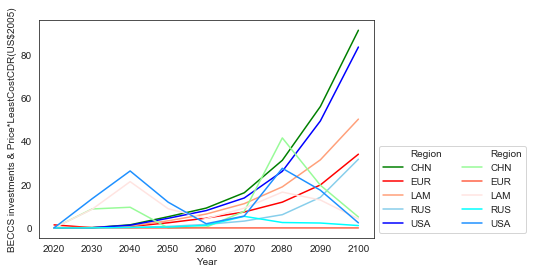

In [101]:
rego = ['LAM', 'USA', 'CHN', 'RUS', 'EUR']
scen='SSP1-19-SPA1-V17'
PriceXCDRperBillion=main_remind['PriceXTotalCDR'].astype(float)/1000000000
single_scen=main_remind[(main_remind.Scenario==scen) &
                        (main_remind.Region.isin(rego))].copy()
ax=sns.lineplot(x='Year',y=PriceXCDRperBillion ,data=single_scen, hue="Region", palette=['green','red','lightsalmon','skyblue','blue'], legend="full")
ax=sns.lineplot(x='Year',y='BECCS_Investments',data=single_scen, hue="Region", palette=['palegreen','tomato','mistyrose','aqua','dodgerblue'])
ax.set(xlabel='Year', ylabel='BECCS investments & Price*LeastCostCDR(US$2005)')
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)
plt.show()
#plt.savefig(plot_path + 'Annual_BECCS_vs_Price*LeastCostCDR.png', bbox_inches='tight')

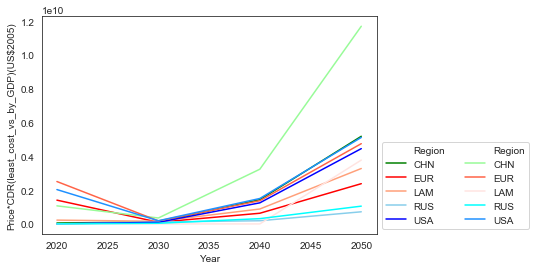

In [118]:
rego = ['LAM', 'USA', 'CHN', 'RUS', 'EUR']
scen='SSP1-19-SPA1-V17'
yr=['2020','2030','2040','2050']
single_scen=main_remind[(main_remind.Scenario==scen) &
                        (main_remind.Region.isin(rego)
                        )& (main_remind.Year.isin(yr))].copy()
ax=sns.lineplot(x='Year',y='PriceXTotalCDR',data=single_scen, hue="Region", palette=['green','red','lightsalmon','skyblue','blue'], legend="full")
ax=sns.lineplot(x='Year',y='CDR_fair_share_by_GDPXCarbonPrice',data=single_scen, hue="Region", palette=['palegreen','tomato','mistyrose','aqua','dodgerblue'])
ax.set(xlabel='Year', ylabel='Price*CDR(least_cost_vs_by_GDP)(US$2005)')
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)
#plt.show()
plt.savefig(plot_path + 'Price*LeastCostCDR_vs_Price*CDRbyGDP.png', bbox_inches='tight')

In [115]:
single_scen=allmodels_equal_df[(allmodels_equal_df.Region.isin(rego)
                               )&(allmodels_equal_df.Scenario==scen
                                 )&(allmodels_equal_df.MODEL=='REMIND')].copy()
single_scen

,Unnamed: 0,Unnamed: 0.1,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,CUM_CO2,CUM_CDR,Unit_CO2,BECCS_Investments,CUM_BECCS_Investments,Unit_Investment,Carbon_Price,Unit_CarbonPrice,PriceXTotalCDR,Unit_PriceXTotalCDR,Population,GDP,Unit_Population,cumPopulation,2016_emissions,em_change,Unit_GDP,GDP_cap,GDP_cap_avg,GDP_cap_CoI_nan,GDP_cap_CoI,GDP_CoI_nan,GDP_CoI,GDP_CoI_frac,CDR_fair_share_by_GDP,CDR_fair_share_by_GDPXCarbonPrice,BECCS_investments_by_GDP,CUM_CDR_fair_share_by_GDP,Global_CUM_CO2_by_CUM_POP,Fair_share_by_CUM_POP,Excess_emissions_by_CUM_POP,Exc_em_fac_by_CUM_POP,CDR_fair_share_by_CUM_POP,CUM_CDR_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_GDP,CUM_CDR_model_vs_fair_share_by_CUM_POP,CUM_CDR_model_vs_fair_share_by_GDP,BECCS_Investments_by_POP,CUM_BECCS_Investments_by_POP,CDR_fair_share_by_CUM_POPXCarbonPrice,CDR_model_vs_FairShareXCarbonPrice_by_GDP,CDR_model_vs_FairShareXCarbonPrice_by_POP,CDRXCarbonPrice_by_POP,CUM_CDR_fair_share_by_GDPXCarbonPrice,CUM_PriceXTotalCDR,CUM_BECCS_investments_by_GDP,CUM_CDR_fair_share_by_CUM_POPXCarbonPrice
9,9.0,9.0,REMIND,CHN,SSP1-19-SPA1-V17,2020.0,9004.3214,11750.00,0.0049,10.5521,10.5570,11760.5570,242900.295827,10.5570,Mt/yr,0.0013,0.0013,billion US$2005/yr,5.000,US$2005/t CO2,5.278500e+07,US$2005/yr,1379.00,21050000.0,Mio,40161.527517,12441.575603,0.945263,USD Million,15264.684554,13416.412568,15264.684554,15264.684554,21050000.0,21050000.0,0.310083,214.169804,1.070849e+09,0.004341,214.169804,6.797535,272999.406122,-30099.110295,NaN,0.000000,0.000000,-10.557000,203.612804,-10.557000,203.612804,0.000000,0.000000,0.000000,1.018064e+09,-5.278500e+07,0.000000,1.070849e+09,5.278500e+07,0.004341,0.000000
10,10.0,10.0,REMIND,CHN,SSP1-19-SPA1-V17,2030.0,5958.0022,7822.00,91.2200,11.3353,102.5553,7924.5553,341325.857327,576.1185,Mt/yr,8.7680,43.8478,billion US$2005/yr,1.145,US$2005/t CO2,1.174258e+08,US$2005/yr,1368.00,38430000.0,Mio,53896.527517,12441.575603,0.636941,USD Million,28092.105263,18619.142572,28092.105263,28092.105263,38430000.0,38430000.0,0.399211,306.229234,3.506325e+08,17.529334,2601.995192,6.475300,348996.170542,-7670.313215,NaN,0.000000,0.000000,-102.555300,203.673934,-576.118500,2025.876692,0.000000,0.000000,0.000000,2.332067e+08,-1.174258e+08,0.000000,7.107407e+09,8.510541e+08,87.668374,0.000000
11,11.0,11.0,REMIND,CHN,SSP1-19-SPA1-V17,2040.0,2758.0046,3952.00,754.1000,16.9026,771.0026,4723.0026,404563.646827,4943.9080,Mt/yr,9.5710,135.5428,billion US$2005/yr,1.865,US$2005/t CO2,1.437920e+09,US$2005/yr,1318.00,56660000.0,Mio,67326.527517,12441.575603,0.379615,USD Million,42989.377845,25680.047933,42989.377845,42989.377845,56660000.0,56660000.0,0.437620,1738.260995,3.241857e+09,37.057678,12824.446340,5.933099,399454.977477,5108.669350,0.011107,44.118206,351.821061,-726.884394,967.258395,-4592.086939,7880.538340,0.940548,9.580797,82.280455,1.803937e+09,-1.437920e+09,82.280455,2.506985e+10,8.627782e+09,360.603434,0.000000
12,12.0,12.0,REMIND,CHN,SSP1-19-SPA1-V17,2050.0,200.2172,1142.00,1691.0000,18.2955,1709.2955,2851.2955,442435.137327,17345.3985,Mt/yr,0.0034,183.4148,billion US$2005/yr,3.038,US$2005/t CO2,5.192840e+09,US$2005/yr,1234.00,69850000.0,Mio,80086.527517,12441.575603,0.229175,USD Million,56604.538088,33297.960146,56604.538088,56604.538088,69850000.0,69850000.0,0.391894,3855.456216,1.171288e+10,16.412518,40793.032397,5.380471,430903.247059,11531.890268,0.022422,220.587035,2258.465463,-1488.708465,2146.160716,-15086.933037,23447.633897,0.939030,33.529377,670.143413,6.520036e+09,-5.192839e+09,670.143413,9.984352e+10,4.178158e+10,627.954417,0.000000
13,13.0,13.0,REMIND,CHN,SSP1-19-SPA1-V17,2060.0,-1087.9968,-324.40,1832.0000,23.6762,1855.6762,1531.2762,464347.995827,35170.2570,Mt/yr,0.3491,185.1773,billion US$2005/yr,4.949,US$2005/t CO2,9.183742e+09,US$2005/yr,1127.00,75180000.0,Mio,91891.527517,12441.575603,0.123077,USD Million,66708.074534,41109.530583,66708.074534,66708.074534,75180

In [114]:
rego = ['LAM', 'USA', 'CHN', 'RUS', 'EUR']
scen='SSP1-19-SPA1-V17'
CDR_by_GDPXPriceperBillion=allmodels_equal_df['CDR_fair_share_by_GDPXCarbonPrice'].astype(float)/1000000000
single_scen=allmodels_equal_df[(allmodels_equal_df.Region.isin(rego)
                               )&(allmodels_equal_df.Scenario==scen
                                 )&(allmodels_equal_df.MODEL=='REMIND')].copy()
sns.lineplot(x='Year',y=CDR_by_GDPXPriceperBillion ,data=single_scen, hue="Region", palette=['green','red','lightsalmon','skyblue','blue'], legend="full")
sns.lineplot(x='Year',y='BECCS_investments_by_GDP',data=single_scen, hue="Region", palette=['palegreen','tomato','mistyrose','aqua','dodgerblue'])
#ax.set(xlabel='Year', ylabel='BECCS investments & Price*LeastCostCDR(US$2005)')
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)
plt.show()
#plt.savefig(plot_path + 'Annual_BECCS_vs_Price*LeastCostCDR.png', bbox_inches='tight')

ValueError: cannot reindex from a duplicate axis

In [106]:
rego = ['USA']
scen=['SSP1-19-SPA0-V17', 
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17']
single_rego=allmodels_equal_df[(allmodels_equal_df.Scenario.isin(scen)) &
                        (allmodels_equal_df.Region.isin(rego))].copy()
single_rego

,Unnamed: 0,Unnamed: 0.1,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,CUM_CO2,CUM_CDR,Unit_CO2,BECCS_Investments,CUM_BECCS_Investments,Unit_Investment,Carbon_Price,Unit_CarbonPrice,PriceXTotalCDR,Unit_PriceXTotalCDR,Population,GDP,Unit_Population,cumPopulation,2016_emissions,em_change,Unit_GDP,GDP_cap,GDP_cap_avg,GDP_cap_CoI_nan,GDP_cap_CoI,GDP_CoI_nan,GDP_CoI,GDP_CoI_frac,CDR_fair_share_by_GDP,CDR_fair_share_by_GDPXCarbonPrice,BECCS_investments_by_GDP,CUM_CDR_fair_share_by_GDP,Global_CUM_CO2_by_CUM_POP,Fair_share_by_CUM_POP,Excess_emissions_by_CUM_POP,Exc_em_fac_by_CUM_POP,CDR_fair_share_by_CUM_POP,CUM_CDR_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_GDP,CUM_CDR_model_vs_fair_share_by_CUM_POP,CUM_CDR_model_vs_fair_share_by_GDP,BECCS_Investments_by_POP,CUM_BECCS_Investments_by_POP,CDR_fair_share_by_CUM_POPXCarbonPrice,CDR_model_vs_FairShareXCarbonPrice_by_GDP,CDR_model_vs_FairShareXCarbonPrice_by_POP,CDRXCarbonPrice_by_POP,CUM_CDR_fair_share_by_GDPXCarbonPrice,CUM_PriceXTotalCDR,CUM_BECCS_investments_by_GDP,CUM_CDR_fair_share_by_CUM_POPXCarbonPrice
90,90.0,90.0,REMIND,USA,SSP1-19-SPA1-V17,2020.0,5001.469000,6175.000000,0.004300,0.000000,0.004300,6175.004300,206990.962923,0.004300,Mt/yr,0.001200,0.001200,billion US$2005/yr,12.000000,US$2005/t CO2,5.160000e+04,US$2005/yr,340.500000,1.667000e+07,Mio,9240.804655,6491.042118,0.951312,USD Million,48957.415565,13416.412568,48957.415565,48957.415565,1.667000e+07,1.667000e+07,0.245562,169.606206,2.035274e+09,0.003438,169.606206,6.797535,62814.697022,144176.265901,0.459614,317.448153,317.448153,317.443853,169.601906,317.443853,169.601906,0.006435,0.006435,3.809378e+03,2.035223e+09,-4.779062e+04,3.809378e+03,2.035274e+09,5.160000e+04,0.003438,3809.377837
91,91.0,91.0,REMIND,USA,SSP1-19-SPA1-V17,2030.0,3788.000100,4622.000000,83.890000,0.000000,83.890000,4705.890000,261395.434423,419.475800,Mt/yr,13.500000,67.507200,billion US$2005/yr,1.145000,US$2005/t CO2,9.605405e+07,US$2005/yr,367.200000,2.065000e+07,Mio,12779.304655,6491.042118,0.724982,USD Million,56236.383442,18619.142572,56236.383442,56236.383442,2.065000e+07,2.065000e+07,0.214512,164.549406,1.884091e+08,9.419223,1670.778062,6.475300,82749.828092,178645.606331,0.455673,349.540618,3636.060438,265.650618,80.659406,3216.584638,1251.302262,20.008586,100.081209,4.002240e+02,9.235502e+07,-9.605365e+07,4.002240e+02,1.111842e+10,4.805282e+08,47.113304,0.000000
92,92.0,92.0,REMIND,USA,SSP1-19-SPA1-V17,2040.0,2233.031500,2891.000000,669.500000,0.351400,669.851400,3560.851400,302729.141423,4188.182800,Mt/yr,26.370000,266.857200,billion US$2005/yr,1.865000,US$2005/t CO2,1.249273e+09,US$2005/yr,392.100000,2.633000e+07,Mio,16575.804655,6491.042118,0.548579,USD Million,67151.236929,25680.047933,67151.236929,67151.236929,2.633000e+07,2.633000e+07,0.203363,807.772891,1.506496e+09,17.220767,6532.389549,5.933099,98345.896028,204383.245395,0.444363,1765.043215,14075.354116,1095.191815,137.921491,9887.171316,2344.206749,37.628644,383.300261,3.291806e+03,2.572236e+08,-1.249270e+09,3.291806e+03,1.959295e+10,7.207163e+09,180.313255,0.000000
93,93.0,93.0,REMIND,USA,SSP1-19-SPA1-V17,2050.0,287.368900,991.200000,1467.000000,1.485900,1468.485900,2459.685900,332831.827923,14879.869300,Mt/yr,11.910000,458.257200,billion US$2005/yr,3.038000,US$2005/t CO2,4.461260e+09,US$2005/yr,414.000000,3.056000e+07,Mio,20606.304655,6491.042118,0.378935,USD Million,73816.425121,33297.960146,73816.425121,73816.425121,3.056000e+07,3.056000e+07,0.171457,1686.796592,5.124488e+09,7.180624,19005.236965,5.380471,110871.626739,221960.201183,0.431566,4245.751698,43469.842063,2777.265798,218.310692,28589.972763,4125.367665,18.073990,645.357101,1.289859e+04,6.632279e+08,-4.461247e+09,1.289859e+04,5.274787e+10,3.575983e+10,302.320210,0.000000
94,94.0,94.0,REMIND,USA,SSP1-19-SPA1-V17,2060.0,-1040.000300,-307.600000,1619.000000,3.600700,1622.600700,1315.000700,351705.260923,30335.302300,Mt/yr,1.930000,527.457200

No handles with labels found to put in legend.


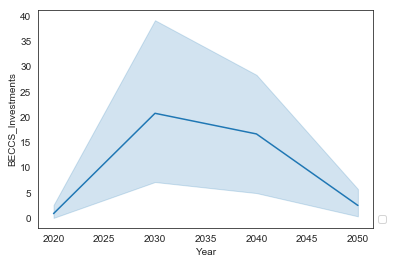

In [110]:
rego = ['USA']
scen=['SSP1-19-SPA0-V17', 
 'SSP2-LF-SPA2-V17', 'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17',
 'SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
 'SSP5-26-SPA5-V17']
yr=['2020','2030','2040','2050']
single_rego=allmodels_equal_df[(allmodels_equal_df.Scenario.isin(scen)
                               ) & (allmodels_equal_df.Region.isin(rego)
                                   ) & (allmodels_equal_df.Year.isin(yr))].copy()
sns.lineplot(x='Year',y='BECCS_Investments',data=single_rego, legend="full") #hue="Scenario"
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)

# (OLD PLOTS)

In [331]:
allmodels_df.to_excel(data_path + 'allmodels_df_plot_table.xls')

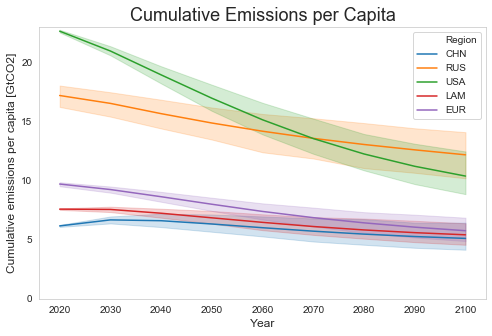

In [528]:
# Conceptual Figure - Cum emissions per cap 

# List of regions of interest
regions=['USA','EUR','CHN','RUS', 'LAM']
variable = 'CUM_CO2_per_cap'

df = allmodels_df[(allmodels_df.Region.isin(regions))]

f,ax=plt.subplots(figsize=(8,5))
ax = sns.lineplot(x='Year',y='CUM_CO2_per_cap',data=df,hue='Region', ax=ax)
ax.set(ylim=(0, 23))
ax.set_ylabel('Cumulative emissions per capita [GtCO2]', fontsize = 12)
ax.grid(False)
ax.set_title('Cumulative Emissions per Capita', fontsize = 18)
ax.set_xlabel('Year', fontsize = 12)
#ax[1,0].legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)

plt.savefig(plot_path + 'F - Concept.Fig - Cum_em.png')

/Users/susannebaur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


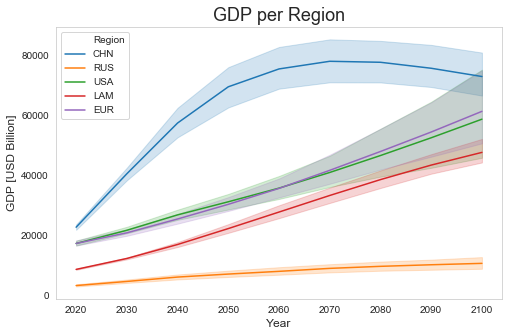

In [531]:
# Conceptual Figure - GDP 
df = allmodels_df[(allmodels_df.Region.isin(regions))]

df['GDP_Bil'] = df.loc[:,'GDP']/1000 #USD Million 

f,ax=plt.subplots(figsize=(8,5))
ax = sns.lineplot(x='Year',y='GDP_Bil',data=df,hue='Region', ax=ax)
ax.grid(False)
ax.set_title('GDP per Region', fontsize = 18)
ax.set_ylabel('GDP [USD Billion]', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)

plt.savefig(plot_path + 'F - Concept.Fig - GDP.png')